In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import arrow
import warnings

warnings.filterwarnings('ignore')

In [2]:
events_calendar = pd.read_pickle('./data/events_calendar.pickle')
product_data = pd.read_pickle('./data/product_data.pickle')
product_history = pd.read_pickle('./data/product_history.pickle')

In [3]:
oct23_event = events_calendar[events_calendar.event == 'Oct23_event']

In [4]:
oct23_event_history = product_history[(product_history.data_date >= oct23_event.event_start_time.values[0]) & (product_history.data_date <= oct23_event.event_end_time.values[0])]

In [5]:
oct23_sum = oct23_event_history.groupby(by='fsn')[['alpha_gross_gmv', 'alpha_gross_units', 'alpha_impressions', 'alpha_primary_ppvs']].sum()

In [6]:
oct23_highest_rev = oct23_sum.sort_values('alpha_gross_gmv').tail(1)
oct23_highest_sold = oct23_sum.sort_values('alpha_gross_units').tail(1)
oct23_highest_views = oct23_sum.sort_values('alpha_primary_ppvs').tail(1)

In [7]:
print(f'Highest Interest Measured by Views: {product_data[product_data.fsn == oct23_highest_views.index.values[0]].name.values[0]}')
print(f'Highest Sold Measured by Units Sold: {product_data[product_data.fsn == oct23_highest_sold.index.values[0]].name.values[0]}')
print(f'Highest Revenue Measured by Total Revenue: {product_data[product_data.fsn == oct23_highest_rev.index.values[0]].name.values[0]}')

Highest Interest Measured by Views: Apple iPhone 14 Blue 128 GB
Highest Sold Measured by Units Sold: realme C53 Champion Gold 128 GB 6 GB RAM
Highest Revenue Measured by Total Revenue: Apple iPhone 14 Blue 128 GB


To predict units sold by product in the Jan24 event, we'll use the following procedure:
1. First I'll try to predict the total phones sold. A few assumptions are built into this:
    * Generally, people intending, and ultimately buying, a phone will buy 1 phone and then will buy their next phone at a much later date.
    * This means that we are isolating our prediction to estimating the # of people who are in the market to buy a phone on Flipkart's website, without trying to decide which phone.
    * Although we have 2 years worth of data, we only see event information for the past half year. Could this mean that no events took place prior to the earliest event, or that we simply don't have this data. This will be considered in evaluating the historical sales - normally we would also involve a domain/product manager for this discussion, but one is unavailable for this exercise.
2. We try to predict a relative demand among phones. There are three ways we can proceed with this:
    * Price is the same as the price in the last event (we don't define what that means, yet). So previous events will be heavy indicators of preference.
    * Price is optimized for total revenue. For this, we must be able to measure price elasticity of demand. This may be possible only if we have sufficient variation of historical prices by each product.
    * Price has already been decided upon, meaning that we'll use the average price during the actual Jan24 event as an input.
    * Regardless of these three choices, we assume that all site visitors see the same price.

Let's start by exploring all units sold as we build a decision on how to proceed.

In [8]:
events_calendar

,event,event_start_time,event_end_time
0,Jan24_event,2024-01-13 00:00:00,2024-01-19 00:00:00
1,Dec23_event,2023-12-08 00:00:00,2023-12-16 00:00:00
2,Nov23_event,2023-11-01 00:00:00,2023-11-11 00:00:00
3,Oct23_event,2023-10-21 00:00:00,2023-10-29 00:00:00
4,Sep23_event,2023-10-07 00:00:00,2023-10-15 00:00:00
5,Aug23_event,2023-08-03 00:00:00,2023-08-09 00:00:00
6,Jul23_event,2023-07-11 00:00:00,2023-07-19 00:00:00
7,Jun23_event,2023-06-09 00:00:00,2023-06-14 00:00:00


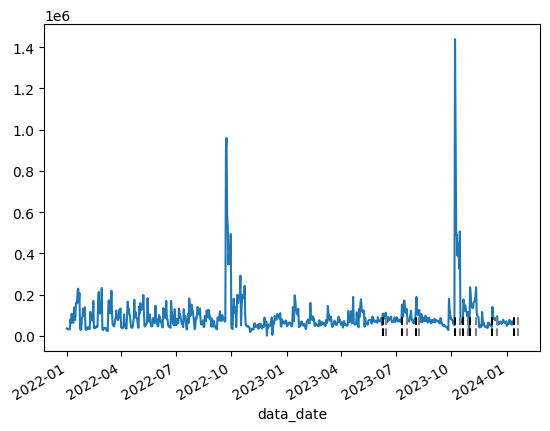

In [9]:
product_history[product_history.data_date <= pd.Timestamp('2024-01-10 00:00:00')].sort_values('data_date').groupby('data_date').alpha_gross_units.sum().plot()
for idx, row in events_calendar.iterrows():
    plt.vlines(row.event_start_time, 0, 1e5, colors='black', linestyles='dashed')
    plt.vlines(row.event_end_time, 0, 1e5, colors='grey', linestyles='dashed')

Firstly, we see that 2022 data is very different from 2023 - more day to day variation during 2022, and more isolated sale bursts in 2023 - suggesting some shift in Flipkart's business model for the phone sector. Perhaps the beginning of events? But it is not timed with the start of our events data.

Secondly, we still see the large spike starting from the Big Billion Days (BBD) sale from 2022 and 2023.

A [brief search online](https://www.livemint.com/technology/tech-news/flipkart-big-billion-days-sale-2022-dates-announced-check-date-deals-offers-11663072184572.html) reveals that in 2022, the BBD sale went from Sept 23 to Sept 30 - this agrees with the data we have.

Similarly, [the BBD sale started on Oct 8](https://www.livemint.com/technology/tech-news/flipkart-big-billion-days-sale-2023-schedule-deals-and-offer-details-11695899121340.html) in 2023, more or less agreeing with our events_calendar.

Regardless, even without access to online research, we can estimate that the sales season starts on with the first anomalous spike, and ends at the last anomalous spike. That corresponds to a mentality of shopping of trying to get in line for the best deals early before they run out - the first spike - and taking advantage of the sales events before it goes away - the last spike.

We will zoom in on this sales season to corroborate this assumption - the 3 events between Oct 7 and Nov 11.

(19634.0, 19675.0)

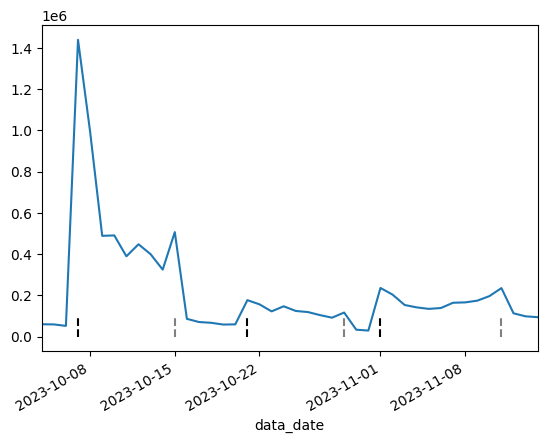

In [10]:
product_history[product_history.data_date <= pd.Timestamp('2024-01-10 00:00:00')].sort_values('data_date').groupby('data_date').alpha_gross_units.sum().plot()
for idx, row in events_calendar.iterrows():
    plt.vlines(row.event_start_time, 0, 1e5, colors='black', linestyles='dashed')
    plt.vlines(row.event_end_time, 0, 1e5, colors='grey', linestyles='dashed')
plt.xlim(arrow.get('2023-10-04 00:00:00').datetime, arrow.get('2023-11-14 00:00:00').datetime)

Let's now find this period during 2022.

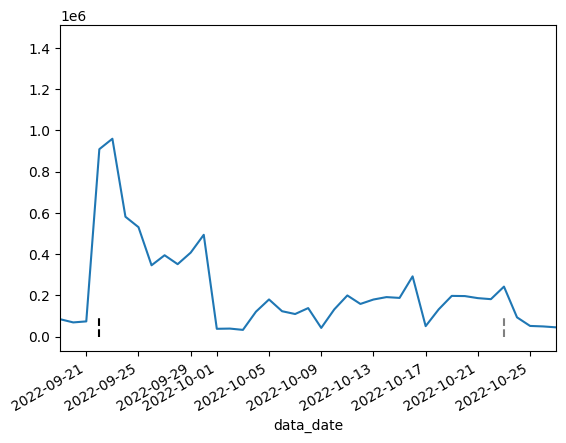

In [11]:
product_history[product_history.data_date <= pd.Timestamp('2024-01-10 00:00:00')].sort_values('data_date').groupby('data_date').alpha_gross_units.sum().plot()
plt.xlim(arrow.get('2022-09-19 00:00:00').datetime, arrow.get('2022-10-27 00:00:00').datetime)
plt.vlines(arrow.get('2022-09-22 00:00:00').datetime, 0, 1e5, colors='black', linestyles='dashed')
plt.vlines(arrow.get('2022-10-23 00:00:00').datetime, 0, 1e5, colors='grey', linestyles='dashed')

We see a similar behavior in the period from Sept 22 and Oct 23.
Although, instead of 3 events, it looks like there were 4 events.

However we will treat these events as similar because:
1. Both are a collection of events closely spaced together in time.
2. They both span over very similar number of calendar days - 32 in 2022 and 36 in 2023.

We will compare the total # of sales in 2022 to the total # of sales in 2023 to establish a baseline growth from-period-to-period and then apply the same technique to scale the sale spike most closely resembling a Jan 2023 event to the Jan 2024 event sales.

Additonally, we won't normalize due to the difference in days, because a large proportion of the sales is due to the events and shoppers mostly shop by event - i.e. whether someone shopped in the 1st or 10th day of an event, they still picked to shop during the event. If the difference was twice as long, perhaps then further considerations would need to be made.

Next let's look for the event in January 2023.

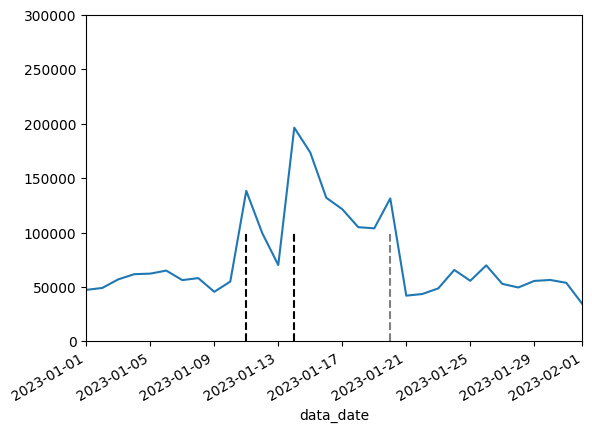

In [12]:
product_history[product_history.data_date <= pd.Timestamp('2024-01-10 00:00:00')].sort_values('data_date').groupby('data_date').alpha_gross_units.sum().plot()
plt.xlim(arrow.get('2023-01-01 00:00:00').datetime, arrow.get('2023-2-01 00:00:00').datetime)
plt.ylim(0, 3e5)
plt.vlines(arrow.get('2023-01-11 00:00:00').datetime, 0, 1e5, colors='black', linestyles='dashed')
plt.vlines(arrow.get('2023-01-14 00:00:00').datetime, 0, 1e5, colors='black', linestyles='dashed')
plt.vlines(arrow.get('2023-01-20 00:00:00').datetime, 0, 1e5, colors='grey', linestyles='dashed')

Here we have another decision to make.
The Jan24 event lasts 7 days (13th to 19th). In 2023 we observe two potential first spikes: on the 11th and 14th (since it is sufficiently larger than the 11th).

One the one hand, selecting the 11th would seem correct because it is so closely spaced to the 14th, but on the other hand, selecting the 14th would yield the same number of event days.

I pick the 14th because unlike the assessment for comparing BBD sales the difference in days 7 v 9 is bigger than 32 v 36, the sales spike during the event is comparatively smaller relative to the daily sales, and the spike on the 11th is also very small compared to that of the 14th. Also, with a little bit of online research, this conclusion is corroborated [here](https://www.livemint.com/news/flipkart-big-savings-days-sale-announced-date-time-and-all-you-need-to-know-11673445530030.html). There is a mention of an early access in the article, but it's only 1 day, and not 3 days.

Also, here we must be slightly careful. Because the sales spike is not significantly larger in volume than the daily baseline sales of ~50,000 units, we must also do a period-to-period adjustment for both these figures, separately.

In [13]:
no_event_base_2024 = product_history[
    (product_history.data_date <= pd.Timestamp('2024-01-05 00:00:00')) \
    & (product_history.data_date >= pd.Timestamp('2023-12-25 00:00:00'))
].groupby('data_date').alpha_gross_units.sum().mean()
no_event_base_2023 = product_history[
    (product_history.data_date <= pd.Timestamp('2023-01-05 00:00:00')) \
    & (product_history.data_date >= pd.Timestamp('2022-12-25 00:00:00'))
].groupby('data_date').alpha_gross_units.sum().mean()

event_Jan24 = product_history[
    (product_history.data_date <= pd.Timestamp('2024-01-19 00:00:00')) \
    & (product_history.data_date >= pd.Timestamp('2024-01-13 00:00:00'))
].alpha_gross_units.sum()
event_Jan23 = product_history[
    (product_history.data_date <= pd.Timestamp('2023-01-20 00:00:00')) \
    & (product_history.data_date >= pd.Timestamp('2023-01-14 00:00:00'))
].alpha_gross_units.sum()

big_event_2023 = product_history[
    (product_history.data_date <= pd.Timestamp('2023-11-11 00:00:00')) \
    & (product_history.data_date >= pd.Timestamp('2023-10-07 00:00:00'))
].alpha_gross_units.sum()
big_event_2022 = product_history[
    (product_history.data_date <= pd.Timestamp('2022-10-23 00:00:00')) \
    & (product_history.data_date >= pd.Timestamp('2022-09-22 00:00:00'))
].alpha_gross_units.sum()

In [14]:
event_Jan24_prediction = round(big_event_2023/big_event_2022 * (event_Jan23 - 7*no_event_base_2023) + 7*no_event_base_2024)
total_sales_pct_err = 100*abs(event_Jan24_prediction - event_Jan24)/event_Jan24
print(f"There is a predicted {event_Jan24_prediction:,} total units sold, with an absolute percent error of {total_sales_pct_err:2.2f}%")

There is a predicted 1,014,315 total units sold, with an absolute percent error of 3.96%


A problem with this method is that we don't actually have any evaluation of the technique prior to evaluating the results on the Jan23 data. However, we also don't have enough event data with which to do some tests - the Dec23 event does not result in a sufficient spike, and there is also not a sufficient spike in Dec22 to match against. We also don't have any clear events to compare prior to Oct 2022, since the sales data prior to Oct 2022 behaves differently.

At best, we can evaluate our year-over-year estimate (i.e. the 'no_event_base' estimate) by comparing the exponentially-weighted-moving-average (EWMA) year-over-year, using our two BBD spikes as two points for comparison.

<Axes: xlabel='data_date'>

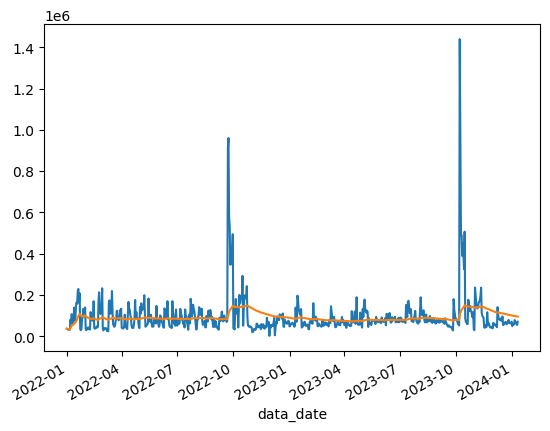

In [15]:
ewma = product_history[
    product_history.data_date <= pd.Timestamp('2024-01-10 00:00:00')
].sort_values('data_date').groupby('data_date').alpha_gross_units.sum().ewm(60).mean()
product_history[
    product_history.data_date <= pd.Timestamp('2024-01-10 00:00:00')
].sort_values('data_date').groupby('data_date').alpha_gross_units.sum().plot()
ewma.plot()

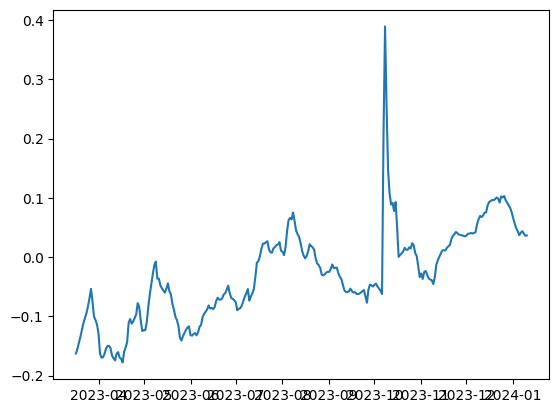

In [16]:
timeDelta = pd.Timestamp('2023-10-07 00:00:00') - pd.Timestamp('2022-09-22 00:00:00')
lastDate = ewma.index[-1] - timeDelta
plt.plot(
    ewma[-300:].index.values,
    (ewma[-300:].values - ewma[ewma.index <= lastDate][-300:].values)/ewma[ewma.index <= lastDate][-300:].values
)


This tells us that there was a dip in daily non-event sales, that picked back up towards the end of 2023. Using December 2023 as a baseline is probably effective.

Because we have such non-stationarity in the data and not enough comparisons that we can make, we have to rely substantially on these qualitative elements in evaluating our prediction of 1,014,315 total sold units. That the actual result turned out to be off by ~4% might be luck or just good estimation, we don't have more that we can say about it.

Now we must look at how to split this prediction by product. First, we will get the daily average buy price for each product by dividing the revenue by units sold.

In [17]:
product_history.loc[:,'avg_buy_price'] = product_history.alpha_gross_gmv / product_history.alpha_gross_units

Below we can see that there is a general decay in price as a product gets older, unless the product is already cheap to begin with.
We also see that products come at different price levels, and were not necessarily bought on the same days.

Note that these are just statements made by intuiting from the below sample.

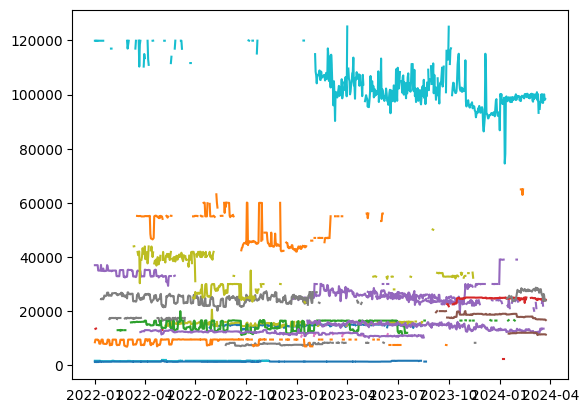

In [18]:
for i, (fsn, grp_df) in enumerate(product_history.groupby('fsn')):
    plt.plot(grp_df.sort_values('data_date').data_date, grp_df.sort_values('data_date').avg_buy_price)
    # print(f"{i} | {fsn} | {len(grp_df)}")
    if i > 100:
        break

Let's get some price distributions based on specific features:
* Brand
* Phone age (from date_added)
* Storage
* Memory
* Base Colors

In [19]:
from pandasql import sqldf

In [20]:
product_data2 = product_data[['fsn', 'brand', 'storage', 'memory', 'premium_cat', 'date_added']]

result = sqldf(
    '''
    select p.brand, p.storage, p.memory, p.premium_cat,
    ROUND((JULIANDAY(h.data_date) - JULIANDAY(p.date_added))/30.5) month_old,
    avg(h.avg_buy_price) price_mean,
    sum(h.alpha_gross_units) units
    from product_data2 p join product_history h
        on p.fsn = h.fsn
    group by p.brand, p.storage, p.memory, p.premium_cat, ROUND((JULIANDAY(h.data_date) - JULIANDAY(p.date_added))/30.5)
    having sum(h.alpha_gross_units) > 0
    '''
)
result

,brand,storage,memory,premium_cat,month_old,price_mean,units
0,ASUS,128.0,8.0,1.000000,0.0,47080.995332,454.0
1,ASUS,128.0,8.0,1.000000,1.0,46558.408714,468.0
2,ASUS,128.0,8.0,1.000000,2.0,46545.563504,396.0
3,ASUS,128.0,8.0,1.000000,3.0,47548.309258,211.0
4,ASUS,128.0,8.0,1.000000,4.0,49120.954107,166.0
...,...,...,...,...,...,...,...
15888,vivo,512.0,16.0,1.000000,1.0,61721.264182,281.0
15889,vivo,512.0,16.0,1.000000,2.0,63005.242949,124.0
15890,vivo,512.0,16.0,1.241207,0.0,74036.797331,1217.0
15891,vivo,512.0,16.0,1.241207,1.0,78826.872926,457.0


Our hypothesis that price decreases with age, while impacting the most expensive phones the most, is confirmed below.

Note that the noise after month 30 is primarily caused by a decrease in the different types of phones being sold - namely, only the more expensive phones are still getting sold on a daily basis after 1.5 years.

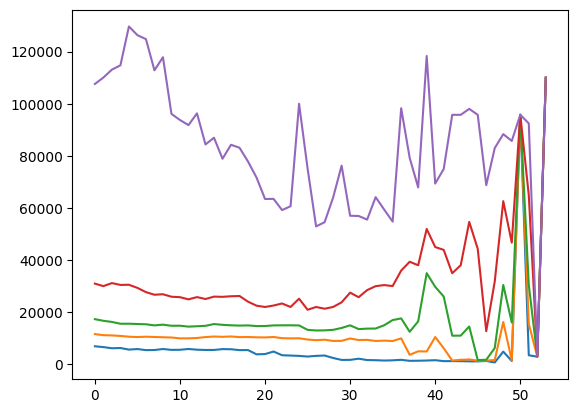

In [21]:
ageplot = plt.plot(result.groupby('month_old').price_mean.agg([
    ('pct_05', lambda x: np.percentile(x, 5)),
    ('pct_25', lambda x: np.percentile(x, 25)),
    ('pct_50', lambda x: np.percentile(x, 50)),
    ('pct_75', lambda x: np.percentile(x, 75)),
    ('pct_95', lambda x: np.percentile(x, 95)),
    # 'count'
]))

Below we see that brand is also an important feature.

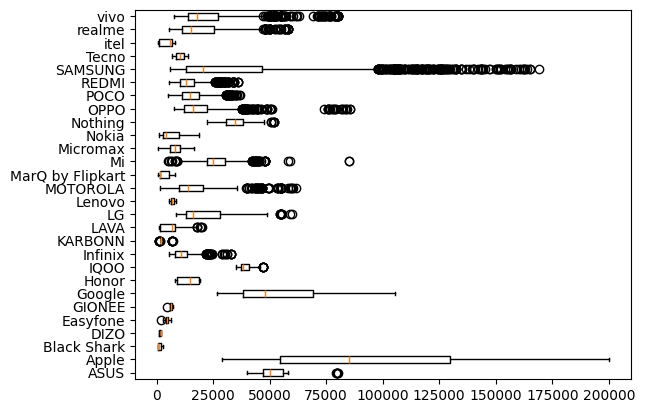

In [22]:
boxp = plt.boxplot([df.price_mean.values for brand, df in result.groupby('brand')], vert=False, labels=[brand for brand, df in result.groupby('brand')])

And similarly, the more storage/memory the higher priced the phone.

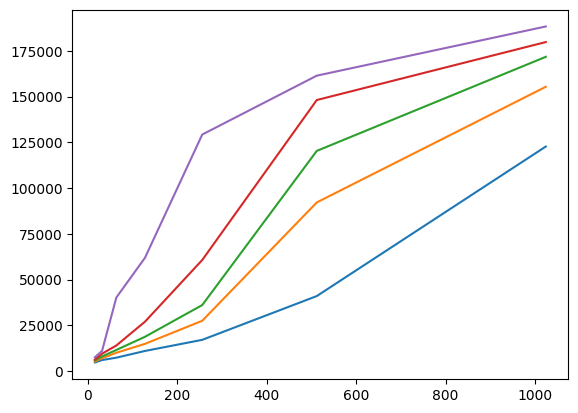

In [23]:
storeplot = plt.plot(result.groupby('storage').price_mean.agg([
    ('pct_05', lambda x: np.percentile(x, 5)),
    ('pct_25', lambda x: np.percentile(x, 25)),
    ('pct_50', lambda x: np.percentile(x, 50)),
    ('pct_75', lambda x: np.percentile(x, 75)),
    ('pct_95', lambda x: np.percentile(x, 95)),
    # 'count'
]))

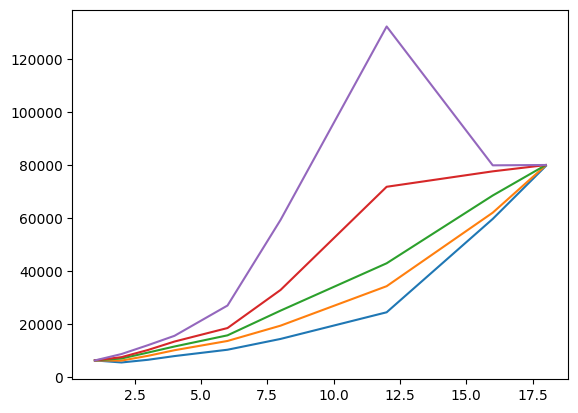

In [24]:
memplot = plt.plot(result.groupby('memory').price_mean.agg([
    ('pct_05', lambda x: np.percentile(x, 5)),
    ('pct_25', lambda x: np.percentile(x, 25)),
    ('pct_50', lambda x: np.percentile(x, 50)),
    ('pct_75', lambda x: np.percentile(x, 75)),
    ('pct_95', lambda x: np.percentile(x, 95)),
    # 'count'
]))

And, finally, it seems that by base color, we don't really see something that should drive our intuition to use it as an inference for price.

In [25]:
base_colors = np.unique(np.concatenate(product_data.colors.values)).tolist()

In [26]:
data = dict()
for color in base_colors:
    fsns = product_data[product_data.colors.apply(lambda x: color in x)].fsn.values.tolist()
    data[color] = product_history[product_history.fsn.isin(fsns)].avg_buy_price.values
    data[color] = data[color][~np.isnan(data[color])]

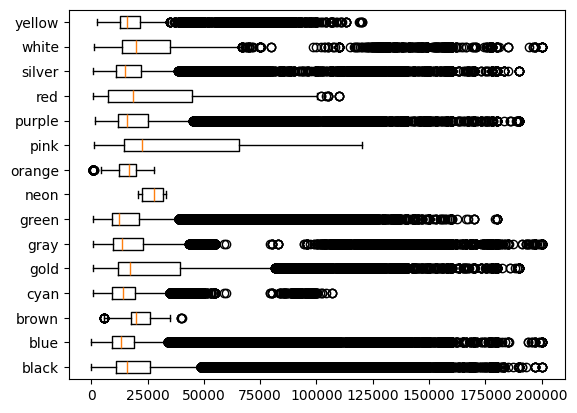

In [27]:
boxp = plt.boxplot(data.values(), vert=False, labels=data.keys())

Before looking at the same features against # sold, let's see how price relates to # sold for a couple of products.
I'll look at two week periods so that Age doesn't affect demand.

In [28]:
events_calendar

,event,event_start_time,event_end_time
0,Jan24_event,2024-01-13 00:00:00,2024-01-19 00:00:00
1,Dec23_event,2023-12-08 00:00:00,2023-12-16 00:00:00
2,Nov23_event,2023-11-01 00:00:00,2023-11-11 00:00:00
3,Oct23_event,2023-10-21 00:00:00,2023-10-29 00:00:00
4,Sep23_event,2023-10-07 00:00:00,2023-10-15 00:00:00
5,Aug23_event,2023-08-03 00:00:00,2023-08-09 00:00:00
6,Jul23_event,2023-07-11 00:00:00,2023-07-19 00:00:00
7,Jun23_event,2023-06-09 00:00:00,2023-06-14 00:00:00


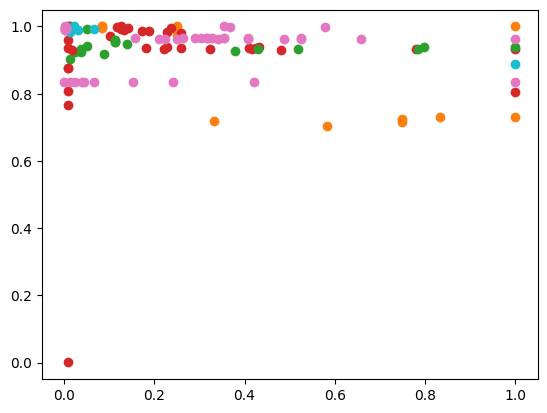

In [29]:
fsns = product_data[
    product_data.date_added <= pd.Timestamp('2023-10-15 00:00:00')
].fsn.values.tolist()

mask = (product_history.data_date <= pd.Timestamp('2023-10-07 00:00:00')) & \
    (product_history.data_date >= pd.Timestamp('2023-09-15 00:00:00')) & \
    product_history.fsn.isin(fsns)
for i, (fsn, grp_df) in enumerate(product_history[mask].groupby('fsn')):
    if i < 100:
        continue
    plt.scatter(
        grp_df.alpha_gross_units/grp_df.alpha_gross_units.max(),
        grp_df.avg_buy_price/grp_df.avg_buy_price.max())
    # print(f"{i} | {fsn} | {len(grp_df)}")
    if i > 130:
        break

The above code was run several times to find if there is really any type of price elasticity of demand by product, and it seems not really. What about across products, but still within the same product grouping:
* Brand
* Memory
* Storage
* Age
* Premium Category

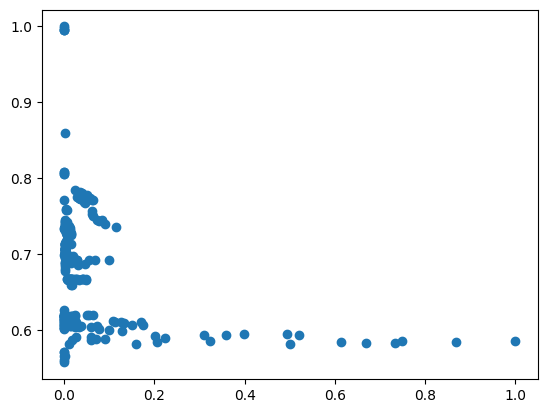

In [50]:
res = dict()
for i, (idx, row) in enumerate(result.sort_values(by='units', ascending=False).iterrows()):
    if i != 2:
        continue
    fsns = product_data[
        (product_data.brand == row.brand) & \
        ((product_data.memory == row.memory) | (product_data.memory.isna() & np.isnan(row.memory))) & \
        ((product_data.storage == row.storage) | (product_data.storage.isna() & np.isnan(row.storage))) & \
        (product_data.premium_cat == row.premium_cat)
    ].fsn.values.tolist()

    df = product_history[product_history.fsn.isin(fsns)].merge(product_data2)
    df = df[((pd.to_datetime(df.data_date) - df.date_added) <= pd.Timedelta(int(row.month_old*30.5 + 15.25), 'D')) & \
    ((pd.to_datetime(df.data_date) - df.date_added) >= pd.Timedelta(int(row.month_old*30.5 - 15.25), 'D'))][['avg_buy_price', 'alpha_gross_units']]

    plt.scatter(
        df.alpha_gross_units / df.alpha_gross_units.max(), df.avg_buy_price / df.avg_buy_price.max()
    )

Looking at a couple of these suggests that there is a tradeaway between daily units sold and daily average price.

Going back to part # 2, spliting the total amount by product. In reality, we cannot evaluate the # units given that the price is different from what the price actually was that day. So instead, we will assume that:
* the price on the following day is given, set and fixed.
* the price is given by the avg_buy_price for that day.

We want to take a look at two new columns, now; the impressions and views.

Two measures are interesting to track here, correlation of impressions to views and correlations between views and # sold, and the price.

We can take a couple of approaches, but we let's try using a distributional regression model. A good distribution to use for counting events - e.g. # units sold - is the Poisson distribution. Here, we will use XGBoost to predict the expected number of units sold given we have # impressions and price for the same day, and we have price, impressions, views, and sold for the previous 8 days.

Here, we assume that competition from other phones does not play a role in establishing sales.

In [51]:
import xgboost as xgb
from xgboost_distribution import XGBDistribution
from scipy import stats

def predictUnits(fsn):
    df = product_history[product_history.fsn == fsn][[
        'data_date',
        'alpha_impressions', 'alpha_primary_ppvs',
        'alpha_gross_units', 'avg_buy_price'
    ]].sort_values('data_date')
    df.index = df.data_date
    df.drop('data_date', axis=1, inplace=True)

    newdf = pd.DataFrame(index=df.index)
    newdf.loc[:,'pred_units'] = df['alpha_gross_units']
    newdf.loc[:,'pred_views'] = df['alpha_primary_ppvs']
    newdf.loc[:,'price'] = df['avg_buy_price'].ffill()
    newdf.loc[:,'ads'] = df['alpha_impressions']
    for j in range(1, 8):
        newdf.loc[:,f'ads{j}'] = newdf.ads.shift(j)
        newdf.loc[:,f'price{j}'] = newdf.price.shift(j)
        newdf.loc[:,f'views{j}'] = newdf.pred_views.shift(j)
        newdf.loc[:,f'units{j}'] = newdf.pred_units.shift(j)
    
    n = len(newdf)
    tP = 0.5
    trainX, trainY = newdf.values[:round(n*tP),2:], newdf.values[:round(n*tP), 0]
    testX, testY, testTS = newdf.values[round(n*tP):,2:], newdf.values[round(n*tP):, 0], newdf.index.values[round(n*tP):]

    model = XGBDistribution(
        distribution="poisson",
        n_estimators=500,
        max_depth=5,
        learning_rate=0.04,
        early_stopping_rounds=5
    )
    model.fit(trainX, trainY.astype(int), eval_set=[(testX, testY.astype(int))], verbose=False)

    testYpred = model.predict(testX)
    low = stats.poisson.ppf(0.10, testYpred).T
    med = stats.poisson.ppf(0.50, testYpred).T
    high = stats.poisson.ppf(0.90, testYpred).T

    plt.figure(figsize=(15, 8))
    plt.plot(testTS, testY, "b.", markersize=10, label="Observation")
    plt.plot(testTS, med, "r-", label="Predicted Mean")
    plt.plot(testTS, high, "k-")
    plt.plot(testTS, low, "k-")
    plt.fill_between(
        np.ravel(testTS), np.ravel(low), np.ravel(high), alpha=0.4, label=f"Predicted {80}% interval"
    )
    plt.xlabel(f"Date")
    plt.ylabel(f"Units Sold")
    plt.legend(loc="upper left")
    plt.legend(loc='upper center')
    for idx, row in events_calendar.iterrows():
        plt.vlines(row.event_start_time, 0, max(testY), colors='black', linestyles='dashed')
        plt.vlines(row.event_end_time, 0, max(testY), colors='grey', linestyles='dashed')
    plt.show()


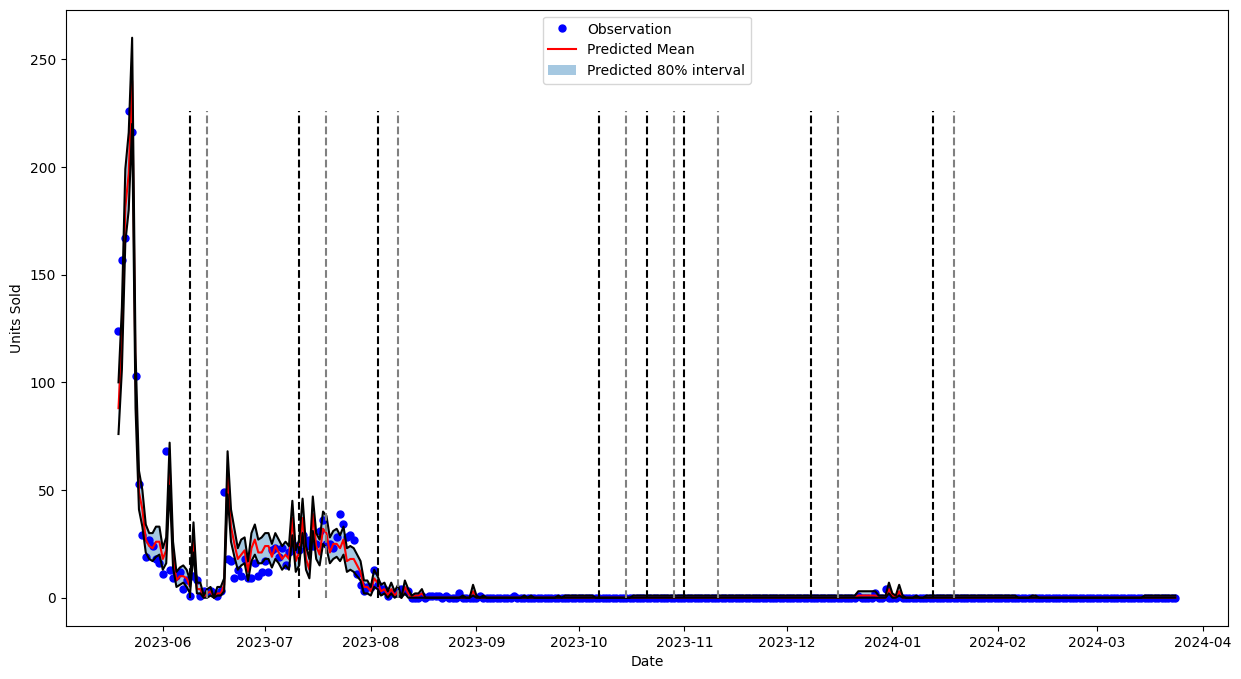

In [52]:
# ['FSQYBFU', 'XN6WRB3', 'CFVMDCX', 'BH3G73H', 'V7GUFWA']) 22DS8Y7
predictUnits('22DS8Y7')

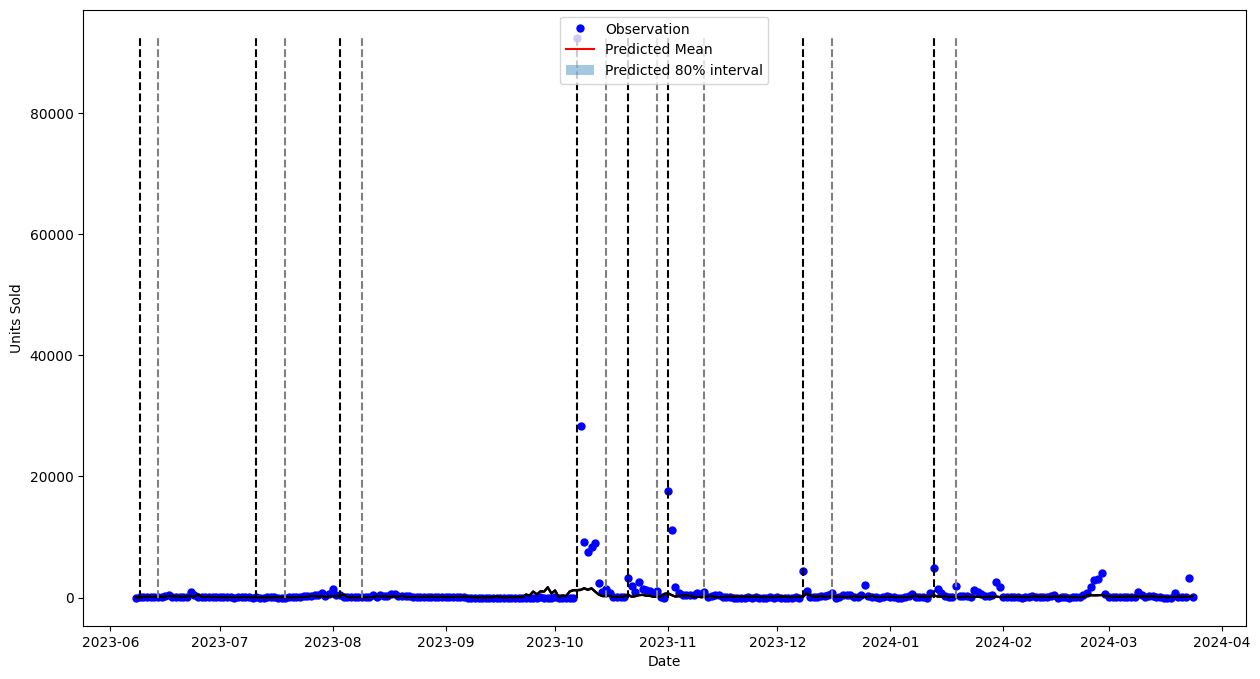

In [53]:
predictUnits('FSQYBFU')

Trying the above code yields various results. Some are good and some are bad.

I show two contrasting examples. The first is an older product and most of the sales data is driven by non-event traffic to the website.

But in the second example, the spikes in sales do not get predicted well. Perhaps once we include product features, then these predictions will come out much better.

Now, let's look at sales as a percent of total.

In [54]:
product_history_agg = product_history.groupby('data_date')[['alpha_gross_units']].sum()

product_history = sqldf(
    '''
    select h.*, h.alpha_gross_units / g.alpha_gross_units pct_total_sales
    from product_history h join product_history_agg g
        on h.data_date = g.data_date
    '''
)

In [55]:
product_history.loc[:, 'data_date'] = pd.to_datetime(product_history.data_date) # because sqldf resets dates to str

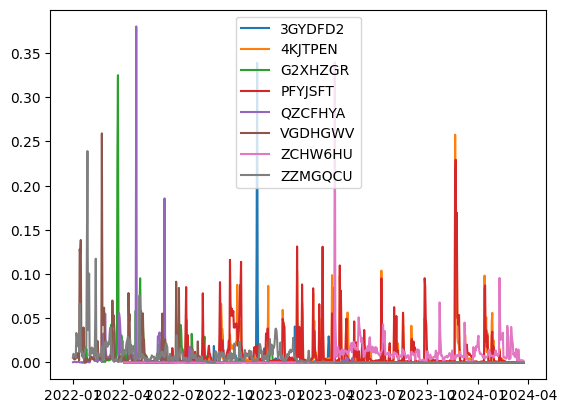

In [56]:
mask = product_history.fsn.isin(['QZCFHYA', 'ZCHW6HU', '3GYDFD2', 'G2XHZGR', 'VGDHGWV', '4KJTPEN', 'ZZMGQCU', 'PFYJSFT'])
for fsn, grp_df in product_history[mask].groupby('fsn'):
    plt.plot(grp_df.sort_values('data_date').data_date, grp_df.sort_values('data_date').pct_total_sales, label=fsn)
plt.legend()

Similarly, we see that percent of total sales is also quite noisy. But offers another possible feature to use.

It seems that at the product level we will also need to perform period-to-period prediction, as daily prediction may not be possible for all products.

Let's start by estimating: views = $\alpha$ impressions.

In [74]:
product_history = product_history.merge(product_data[['fsn','brand','date_added','memory','storage','premium_cat']])
product_history['age'] = np.maximum(np.floor((pd.to_datetime(product_history.data_date) - product_history.date_added).dt.days/30.5), 0)
product_history.to_pickle('./data/product_history.pickle')

We see a very steady decrease in the distribution of $\alpha$ with age.
Only at the top tail is the conversion jumpy, maybe due to an increase of views related to events, or just the noisy tail of fewer products.
We see that generally, only new products will experience a large surge, and only few of those will have a very high demand.

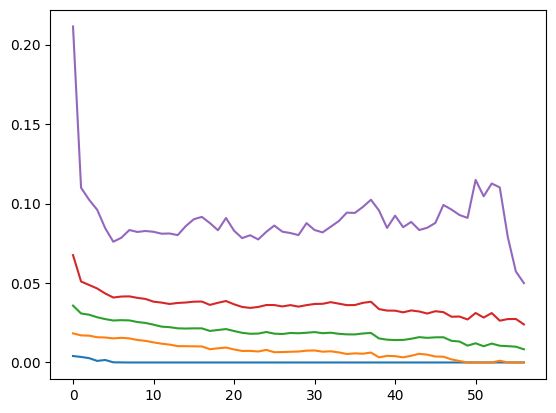

In [97]:
ages = []
for age, grp_df in product_history.groupby('age'):
    vals = (grp_df.alpha_primary_ppvs / grp_df.alpha_impressions).values
    if len(vals[~np.isnan(vals)]) == 0:
        continue
    ages.append(np.percentile(vals[~np.isnan(vals)], [5, 25, 50, 75, 95]))
_ = plt.plot(np.array(ages))

Similarly with: bought = $\beta$ views.

We see a decrease with age, and the spike may be the result of event sales. But it could also be a result of a decrease in impressions.

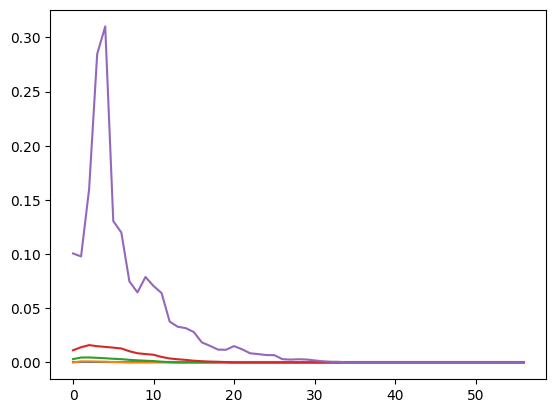

In [98]:
ages = []
for age, grp_df in product_history.groupby('age'):
    vals = (grp_df.alpha_gross_units / grp_df.alpha_primary_ppvs).values
    if len(vals[~np.isnan(vals)]) == 0:
        continue
    ages.append(np.percentile(vals[~np.isnan(vals)], [5, 25, 50, 75, 95]))
_ = plt.plot(np.array(ages))

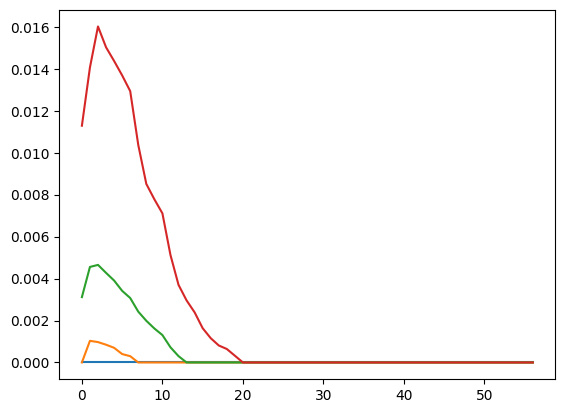

In [99]:
_ = plt.plot(np.array(ages)[:,:4])

Now let's look at: bought = $\gamma$ impressions

These results suggest that we can bypass looking at views altogether to help predict sales.

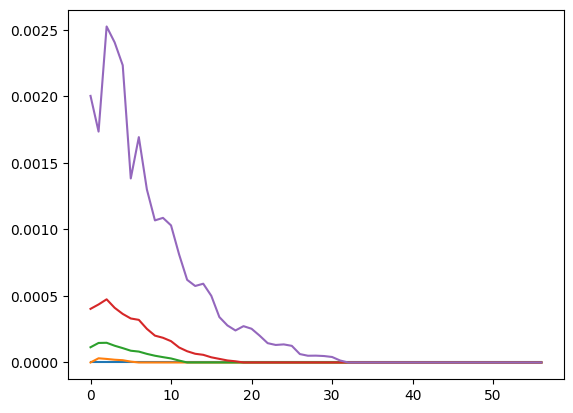

In [100]:
ages = []
for age, grp_df in product_history.groupby('age'):
    vals = (grp_df.alpha_gross_units / grp_df.alpha_impressions).values
    if len(vals[~np.isnan(vals)]) == 0:
        continue
    ages.append(np.percentile(vals[~np.isnan(vals)], [5, 25, 50, 75, 95]))
_ = plt.plot(np.array(ages))

Looking at a sample of $\alpha$'s by product, we see that when a product is first released, then it may have an intrinsic demand that must be predicted purely from product features.

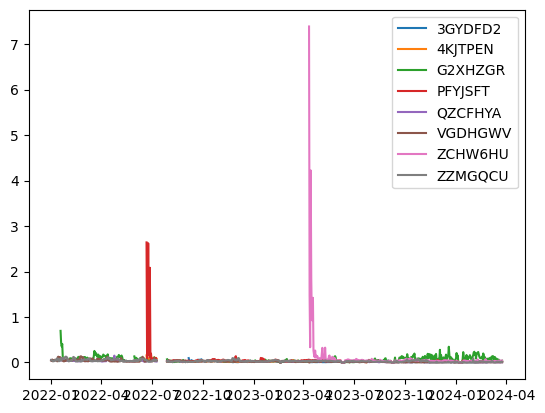

In [108]:
mask = product_history.fsn.isin(['QZCFHYA', 'ZCHW6HU', '3GYDFD2', 'G2XHZGR', 'VGDHGWV', '4KJTPEN', 'ZZMGQCU', 'PFYJSFT'])
for i, (fsn, grp_df) in enumerate(product_history[mask].groupby('fsn')):
    df = grp_df.sort_values('data_date')[[
        'data_date',
        'alpha_impressions', 'alpha_primary_ppvs',
        'alpha_gross_units', 'avg_buy_price'
    ]]
    df.index = df.data_date
    df.drop('data_date', axis=1, inplace=True)
    df.rolling(7).sum()
    # df = df.rolling(7).sum()
    _ = plt.plot(df.alpha_primary_ppvs / df.alpha_impressions, label=fsn)
_ = plt.legend()

In [112]:
product_data[product_data.fsn.isin(['QZCFHYA', 'ZCHW6HU', '3GYDFD2', 'G2XHZGR', 'VGDHGWV', '4KJTPEN', 'ZZMGQCU', 'PFYJSFT'])]

,fsn,when_added_ts,name,brand,date_added,memory,storage,colors,premium_cat,release_avg_price
546,ZCHW6HU,1681381242,vivo T2 5G Nitro Blaze 128 GB 6 GB RAM,vivo,2023-04-13,6.0,128.0,[cyan],1.270702,17135.234567
1081,QZCFHYA,1618072936,realme C20 Cool Grey 32 GB 2 GB RAM,realme,2021-04-10,2.0,32.0,[gray],1.000000,6100.491482
1171,G2XHZGR,1642615086,realme 9i Prism Black 64 GB 4 GB RAM,realme,2022-01-19,4.0,64.0,"[black, purple]",1.000000,11473.800740
1266,3GYDFD2,1662574550,realme C33 Night Sea 64 GB 4 GB RAM,realme,2022-09-07,4.0,64.0,[cyan],1.000000,8557.830865
1889,VGDHGWV,1618072964,SAMSUNG Galaxy F12 Sky Blue 64 GB 4 GB RAM,SAMSUNG,2021-04-10,4.0,64.0,"[blue, cyan]",1.000000,9504.850310
1991,PFYJSFT,1656146292,SAMSUNG Galaxy F13 Waterfall Blue 64 GB 4 GB RAM,SAMSUNG,2022-06-25,4.0,64.0,[blue],1.000000,9495.461667
1992,4KJTPEN,1656146308,SAMSUNG Galaxy F13 Nightsky Green 64 GB 4 GB RAM,SAMSUNG,2022-06-25,4.0,64.0,[green],1.000000,9498.640080
2286,ZZMGQCU,1632765910,REDMI 9i Sport Metallic Blue 64 GB 4 GB RAM,REDMI,2021-09-27,4.0,64.0,[blue],1.022840,7992.243299


In [113]:
events_calendar

,event,event_start_time,event_end_time
0,Jan24_event,2024-01-13 00:00:00,2024-01-19 00:00:00
1,Dec23_event,2023-12-08 00:00:00,2023-12-16 00:00:00
2,Nov23_event,2023-11-01 00:00:00,2023-11-11 00:00:00
3,Oct23_event,2023-10-21 00:00:00,2023-10-29 00:00:00
4,Sep23_event,2023-10-07 00:00:00,2023-10-15 00:00:00
5,Aug23_event,2023-08-03 00:00:00,2023-08-09 00:00:00
6,Jul23_event,2023-07-11 00:00:00,2023-07-19 00:00:00
7,Jun23_event,2023-06-09 00:00:00,2023-06-14 00:00:00
